#### Loading the necessary libraries and packages

In [1]:
# Load tensorflow
import tensorflow as tf
# Below command is to avoid the known bug which prevents computation on some GPU devices
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
# Load preprocessing tools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage.filters import gaussian_filter
from PIL import Image
from PIL.ImageOps import expand
# Load model building blocks
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
# Load pre-trained model library
from tensorflow.keras import applications
# Load miscelaneous libraries
import numpy as np
import os
import matplotlib.pylab as plt
import gc

#### Data preprocessing and augmentation

Load the data from the directory. The data are the images of particles split into subdirectories based on the number of forces acting on the particle. The labels are inferred from the subdirectory names. 

The size of all images is adjusted so that all images are 128*128 using nearest neighbor interpolation. Validation split is performed: 20% is set aside for validation. Additionally images are blurred using Gaussian blur with kernel radius = 1.The pixel values are scaled using 1/255 to be in the interval [0,1].

In [2]:
# Define gaussian blur class
class GaussBlur:
    def __init__(self, radius):
        self.radius = radius
    def blur(self, image):
        return gaussian_filter(image, sigma = self.radius)

In [3]:
# Define datagen and gaussian blur classes
gaussblur = GaussBlur(1)
datagen = ImageDataGenerator(
    rescale = 1 / 255,
    preprocessing_function = gaussblur.blur)

In [4]:
# Create directory iterator for reading in the data
datagen_flow_train = datagen.flow_from_directory(os.path.join(os.getcwd(), 'image_data', 'small', '400', 'train'), 
                                         target_size = (128, 128),
                                         color_mode = "rgb",
                                         class_mode = "categorical",
                                         batch_size = 32,
                                         shuffle = True,
                                         seed = None,
                                         follow_links = False,
                                         interpolation = "nearest")
datagen_flow_val = datagen.flow_from_directory(os.path.join(os.getcwd(), 'image_data', 'small', '400', 'val'), 
                                         target_size = (128, 128),
                                         color_mode = "rgb",
                                         class_mode = "categorical",
                                         batch_size = 32,
                                         shuffle = True,
                                         seed = None,
                                         follow_links = False,
                                         interpolation = "nearest")

Found 1600 images belonging to 5 classes.
Found 400 images belonging to 5 classes.


#### VGG19 Model building

Convolutional neural network is loaded (pre-trained) and compiled in this step.

In [5]:
# Load VGG19 model to be the base model
models_path = os.path.join(os.getcwd(), 'models')
model = load_model(os.path.join(models_path, 'vgg19_num_forces.h5'))   

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 20,554,821
Trainable params: 20,554,821
Non-trainable params: 0
_________________________________________________

#### VGG19 Model Training

The model is trained using Adam optimizer. The loss is defined to be categorical crossentropy. Best model selection across training epochs is implemented with model checkpoint tracking the validation loss. Early stopping is set with patience of 20 epochs. 

In [7]:
# Compile model: define loss, optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-06, epsilon = 1e-07),
              loss='categorical_crossentropy', 
              metrics=['accuracy', 'categorical_crossentropy'])

In [9]:
# Train model
model_path = os.path.join(os.getcwd(), 'models', 'small', '400', 'vgg19_num_forces.h5')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

epochs = 1000

history = model.fit(datagen_flow_train,
                            epochs = epochs,
                            steps_per_epoch = len(datagen_flow_train),
                            validation_data = datagen_flow_val,
                            validation_steps = len(datagen_flow_val),
                            callbacks=[es, mc]
                           )

Epoch 1/1000
50/50 [==============================] - ETA: 0s - loss: 2.7869 - accuracy: 0.8575 - categorical_crossentropy: 2.7869
Epoch 00001: val_loss improved from inf to 0.14281, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/400/vgg19_num_forces.h5
50/50 [==============================] - 20s 404ms/step - loss: 2.7869 - accuracy: 0.8575 - categorical_crossentropy: 2.7869 - val_loss: 0.1428 - val_accuracy: 0.9775 - val_categorical_crossentropy: 0.1428
Epoch 2/1000
50/50 [==============================] - ETA: 0s - loss: 0.4117 - accuracy: 0.9475 - categorical_crossentropy: 0.4117
Epoch 00002: val_loss did not improve from 0.14281
50/50 [==============================] - 6s 116ms/step - loss: 0.4117 - accuracy: 0.9475 - categorical_crossentropy: 0.4117 - val_loss: 0.1713 - val_accuracy: 0.9800 - val_categorical_crossentropy: 0.1713
Epoch 3/1000
50/50 [==============================] - ETA: 0s - loss: 0.2677 - accuracy: 0.9588 - categorical

Epoch 21/1000
50/50 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9987 - categorical_crossentropy: 0.0051
Epoch 00021: val_loss did not improve from 0.04004
50/50 [==============================] - 6s 112ms/step - loss: 0.0051 - accuracy: 0.9987 - categorical_crossentropy: 0.0051 - val_loss: 0.1244 - val_accuracy: 0.9675 - val_categorical_crossentropy: 0.1244
Epoch 22/1000
50/50 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 0.9962 - categorical_crossentropy: 0.0079
Epoch 00022: val_loss improved from 0.04004 to 0.01089, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/400/vgg19_num_forces.h5
50/50 [==============================] - 6s 119ms/step - loss: 0.0079 - accuracy: 0.9962 - categorical_crossentropy: 0.0079 - val_loss: 0.0109 - val_accuracy: 0.9975 - val_categorical_crossentropy: 0.0109
Epoch 23/1000
50/50 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.9981 - categ

Epoch 42/1000
50/50 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000 - categorical_crossentropy: 0.0012
Epoch 00042: val_loss did not improve from 0.01089
50/50 [==============================] - 6s 111ms/step - loss: 0.0012 - accuracy: 1.0000 - categorical_crossentropy: 0.0012 - val_loss: 0.0895 - val_accuracy: 0.9800 - val_categorical_crossentropy: 0.0895
Epoch 43/1000
50/50 [==============================] - ETA: 0s - loss: 7.7436e-04 - accuracy: 1.0000 - categorical_crossentropy: 7.7436e-04
Epoch 00043: val_loss did not improve from 0.01089
50/50 [==============================] - 5s 110ms/step - loss: 7.7436e-04 - accuracy: 1.0000 - categorical_crossentropy: 7.7436e-04 - val_loss: 0.0839 - val_accuracy: 0.9875 - val_categorical_crossentropy: 0.0839
Epoch 44/1000
50/50 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000 - categorical_crossentropy: 0.0013
Epoch 00044: val_loss did not improve from 0.01089
50/50 [==================

Epoch 63/1000
50/50 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 0.9987 - categorical_crossentropy: 0.0027
Epoch 00063: val_loss did not improve from 0.01089
50/50 [==============================] - 6s 111ms/step - loss: 0.0027 - accuracy: 0.9987 - categorical_crossentropy: 0.0027 - val_loss: 0.0899 - val_accuracy: 0.9850 - val_categorical_crossentropy: 0.0899
Epoch 64/1000
50/50 [==============================] - ETA: 0s - loss: 6.2920e-04 - accuracy: 1.0000 - categorical_crossentropy: 6.2920e-04
Epoch 00064: val_loss did not improve from 0.01089
50/50 [==============================] - 6s 111ms/step - loss: 6.2920e-04 - accuracy: 1.0000 - categorical_crossentropy: 6.2920e-04 - val_loss: 0.0542 - val_accuracy: 0.9875 - val_categorical_crossentropy: 0.0542
Epoch 65/1000
50/50 [==============================] - ETA: 0s - loss: 5.3512e-04 - accuracy: 1.0000 - categorical_crossentropy: 5.3512e-04
Epoch 00065: val_loss did not improve from 0.01089
50/50 [==========

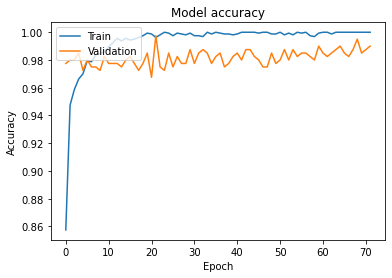

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()